In [1]:
import httplib2
import oauth2
import urllib3
import types
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from gender_detector import GenderDetector 
import psycopg2, psycopg2.extras
from causalinference import CausalModel
from causalinference.utils import random_data
import httplib
import base64
import json # For Microsoft Face API
import urllib as urllib # For Microsoft Face API
import time 
import csv
import datetime 
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Initialize arrays for Causal Analysis 
user_count = 1
bill_rate_array = []
gender_array = []
all_covariates_array = []

# Read data from csv files and reformat
all_data_file_name = './csv_files/2017_12_12_upwork_analysis_unitedstates_allskills.csv' # Filename for all data
gender_data_file_name = './csv_files/2017_12_12_upwork_face_data_unitedstates_allskills.csv' # Filename for gender data
df = pd.read_csv(all_data_file_name)
df_gender = pd.read_csv(gender_data_file_name)

# Merge the files, then remove rows with an error, no gender identified, or ambiguous education
merged = df.merge(df_gender, on='user_count')

# Stats about what we omitted from the dataset
total_merged = len(merged)
bill_rate_errors = len(merged[merged.bill_rate == 'error'])
education_errors = len(merged[merged.education == 'None'])
work_experience_errors = len(merged[merged.work_experience == 'error'])
jobs_completed_errors = len(merged[merged.jobs_completed == 'error'])
job_category_errors = len(merged[merged.job_category == 'none'])
gender_errors = len(merged[merged.gender == 'error'])

print "Total merged: {0}".format(total_merged)
print "Bill rate errors: {0}".format(bill_rate_errors)
print "Education errors: {0}".format(education_errors)
print "Work experience errors: {0}".format(work_experience_errors)
print "Jobs completed errors: {0}".format(jobs_completed_errors)
print "Jobs category errors: {0}".format(job_category_errors)
print "Gender errors: {0}".format(gender_errors)

merged = merged[merged.bill_rate != 'error']
print "Total after bill rate errors: {0}".format(len(merged))
merged = merged[merged.work_experience != 'error']
print "Total after work experience: {0}".format(len(merged))
merged = merged[merged.gender != 'error']
print "Total after gender errors: {0}".format(len(merged))
merged = merged[merged.education != 'None']
print "Total after education: {0}".format(len(merged))
merged = merged[merged.jobs_completed != 'error']
print "Total after jobs_completed: {0}".format(len(merged))
merged = merged[merged.job_category != 'none']
print "Total after job_category: {0}".format(len(merged))

women_data = merged[merged.gender == 'female']
men_data = merged[merged.gender == 'male']

# Calculate mean and standard deviation
merged['bill_rate'] = merged.bill_rate.astype('float')
sd = np.std(merged['bill_rate'])
mean = np.mean(merged['bill_rate'])
median = np.median(merged['bill_rate'])
print "----Overall----"
print("Bill rate average: {0}".format(mean))
print("Bill rate standard deviation: {0}".format(sd))
print ("Bill rate median: {0}".format(median))

# Calculate mean and standard deviation for women 
women_data['bill_rate'] = women_data.bill_rate.astype('float')
women_sd = np.std(women_data['bill_rate'])
women_mean = np.mean(women_data['bill_rate'])
women_median = np.median(women_data['bill_rate'])
print "----Women----"
print("Bill rate average: {0}".format(women_mean))
print("Bill rate standard deviation: {0}".format(women_sd))
print ("Bill rate median: {0}".format(women_median))

# Calculate mean and standard deviation for men
men_data['bill_rate'] = men_data.bill_rate.astype('float')
men_sd = np.std(men_data['bill_rate'])
men_mean = np.mean(men_data['bill_rate'])
men_median = np.median(men_data['bill_rate'])
print "----Men----"
print("Bill rate average: {0}".format(men_mean))
print("Bill rate standard deviation: {0}".format(men_sd))
print ("Bill rate median: {0}".format(men_median))

/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Total merged: 55518
Bill rate errors: 9588
Education errors: 1813
Work experience errors: 9631
Jobs completed errors: 9588
Jobs category errors: 446
Gender errors: 3457
Total after bill rate errors: 45930
Total after work experience: 45887
Total after gender errors: 42972
Total after education: 41440
Total after jobs_completed: 41440
Total after job_category: 41244
----Overall----
Bill rate average: 39.5661373776
Bill rate standard deviation: 39.0716533178
Bill rate median: 30.0
----Women----
Bill rate average: 37.5519937964
Bill rate standard deviation: 39.7809449718
Bill rate median: 27.78
----Men----
Bill rate average: 41.401810177
Bill rate standard deviation: 38.3217098146
Bill rate median: 30.0


/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ecf384/.conda/envs/eureka2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
legal_jobs = merged[(merged['gender'] == 'male') & (merged['job_category'] == 'Legal') ]['bill_rate']

mean_legal_jobs = np.mean(legal_jobs)

print mean_legal_jobs

72.1494736842


## What is the pay discrepancy across job categories on Upwork? 

Male bill rate average: 40.4377019749
Female bill rate average: 37.6143501969
Pay discrepancy for Design & Creative: 6.98197879719%
Male bill rate average: 45.1375162549
Female bill rate average: 46.8830769231
Pay discrepancy for Data Science & Analytics: -3.86720584789%
Male bill rate average: 26.1422985075
Female bill rate average: 25.0230357143
Pay discrepancy for Customer Service: 4.28142457656%
Male bill rate average: 25.23894888
Female bill rate average: 24.6595254572
Pay discrepancy for Admin Support: 2.29575100559%
Male bill rate average: 59.8779279279
Female bill rate average: 52.3475642595
Pay discrepancy for Accounting & Consulting: 12.5761928127%
Male bill rate average: 35.3418855219
Female bill rate average: 33.5638070776
Pay discrepancy for Writing: 5.03107974576%
Male bill rate average: 47.629476787
Female bill rate average: 44.4639259259
Pay discrepancy for Web, Mobile & Software Dev: 6.64620120699%
Male bill rate average: 29.2626156942
Female bill rate average: 27.8078

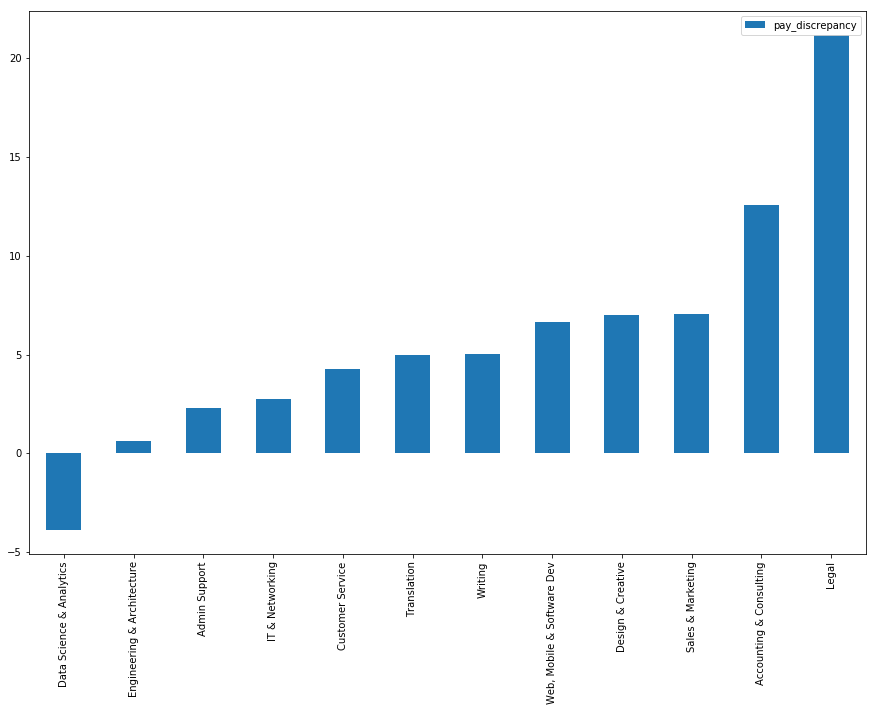

In [64]:
pay_discrepancies = []

job_categories = ['Design & Creative', 'Data Science & Analytics', 'Customer Service', 'Admin Support', 
                 'Accounting & Consulting', 'Writing', 'Web, Mobile & Software Dev', 'Translation', 
                 'Sales & Marketing', 'Legal', 'IT & Networking', 'Engineering & Architecture']

list_of_discrepancies = []

for category in job_categories:
    # Calculate the male average bill rate
    males_with_job = merged[(merged['gender'] == 'male') & (merged['job_category'] == category) ]['bill_rate']
    male_bill_rate_average = np.mean(males_with_job)
    print "Male bill rate average: {0}".format(male_bill_rate_average)
    
    # Calculate the female average bill rate
    females_with_job = merged[(merged['gender'] == 'female') & (merged['job_category'] == category) ]['bill_rate']
    female_bill_rate_average = np.mean(females_with_job)
    print "Female bill rate average: {0}".format(female_bill_rate_average)
    
    female_percentage = float(female_bill_rate_average)/float(male_bill_rate_average) * 100
    
    discrepancy = 100 - female_percentage
    list_of_discrepancies.append(discrepancy)
    
    print "Pay discrepancy for {0}: {1}%".format(category, discrepancy)

discrepancy_df = pd.DataFrame(list_of_discrepancies, index=job_categories, columns=['pay_discrepancy'])
discrepancy_df = discrepancy_df.sort_values('pay_discrepancy')
discrepancy_df.plot(kind="bar", figsize=(15,10))

## What is the representation of women in different job categories on Upwork?

                            female_percentage
Web, Mobile & Software Dev          40.609636
IT & Networking                     41.388889
Data Science & Analytics            41.469993
Accounting & Consulting             45.274320
Engineering & Architecture          45.650373
Design & Creative                   45.720061
Legal                               48.064516
Sales & Marketing                   48.815789
Writing                             51.807229
Translation                         53.403141
Admin Support                       54.073200
Customer Service                    54.799627


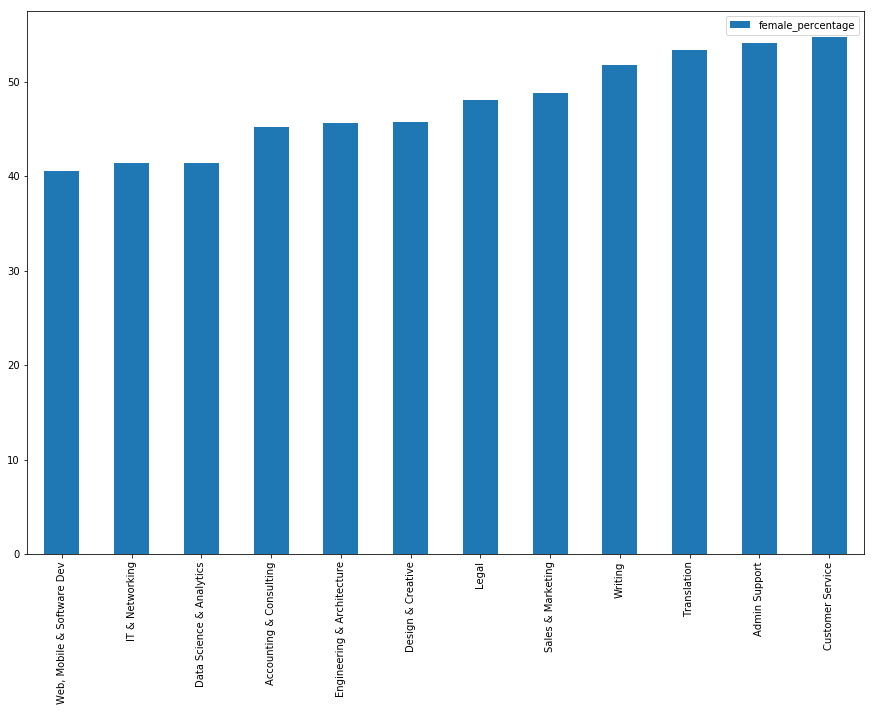

In [2]:
job_categories = ['Design & Creative', 'Data Science & Analytics', 'Customer Service', 'Admin Support', 
                 'Accounting & Consulting', 'Writing', 'Web, Mobile & Software Dev', 'Translation', 
                 'Sales & Marketing', 'Legal', 'IT & Networking', 'Engineering & Architecture']

representation_of_women = []

for category in job_categories:
    
    males_with_job = merged[(merged['gender'] == 'male') & (merged['job_category'] == category)]
    male_total = len(males_with_job)
    
    # Calculate the female average bill rate
    females_with_job = merged[(merged['gender'] == 'female') & (merged['job_category'] == category)]
    female_total = len(females_with_job)
    
    total_in_category = male_total + female_total
    
    female_percentage = float(female_total)/float(total_in_category) * 100

    representation_of_women.append(female_percentage)

representation_df = pd.DataFrame(representation_of_women, index=job_categories, columns=['female_percentage'])

representation_df = representation_df.sort_values('female_percentage')
print representation_df
representation_df.plot(kind="bar", figsize=(15,10))

## What are the highest paying categories on Upwork? 

                            average_bill_rate
Admin Support                       24.927532
Customer Service                    25.538790
Translation                         28.486088
Writing                             34.421728
Design & Creative                   39.143274
Engineering & Architecture          45.421967
Data Science & Analytics            45.852097
Web, Mobile & Software Dev          46.329978
Sales & Marketing                   51.138702
IT & Networking                     56.374038
Accounting & Consulting             56.490094
Legal                               64.720270
Overall average by job category: 43.2370464229
Overall average without job category: 39.8293404168
Total length: 31717


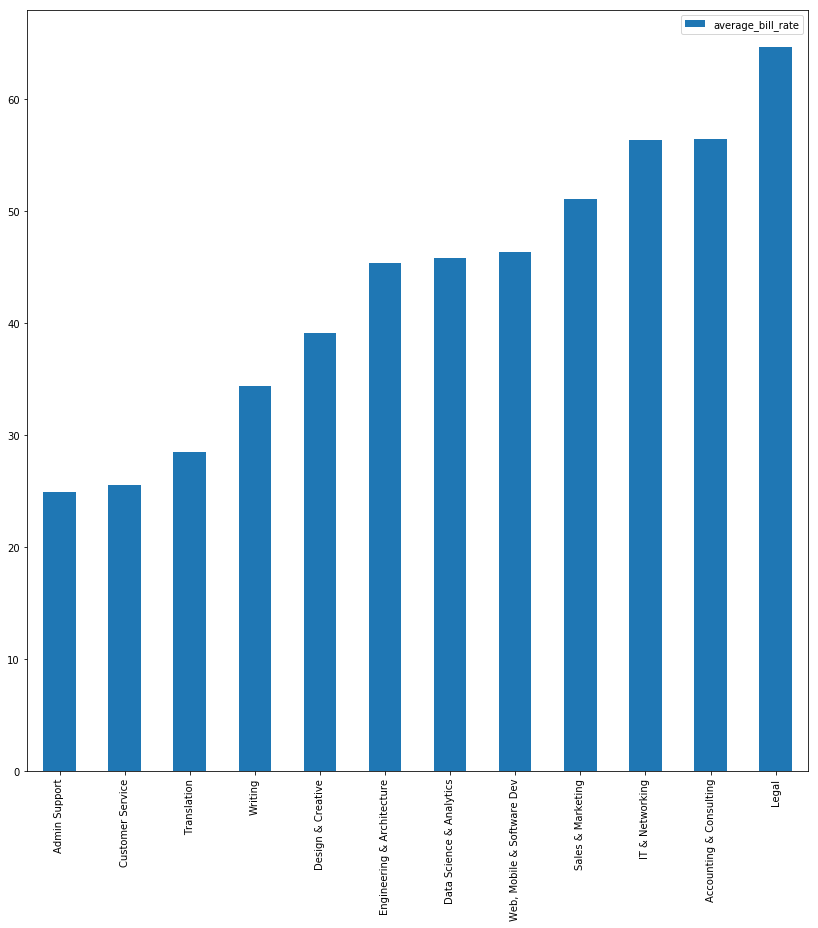

In [63]:
job_categories = ['Design & Creative', 'Data Science & Analytics', 'Customer Service', 'Admin Support', 
                 'Accounting & Consulting', 'Writing', 'Web, Mobile & Software Dev', 'Translation', 
                 'Sales & Marketing', 'Legal', 'IT & Networking', 'Engineering & Architecture']

average_bill_rate = []

total_length = 0

for category in job_categories:
    workers_with_job = merged[(merged['job_category'] == category)]['bill_rate']
    bill_rate_average = np.mean(workers_with_job)
    total_length += len(workers_with_job)
    average_bill_rate.append(bill_rate_average)

bill_rate_df = pd.DataFrame(average_bill_rate, index=job_categories, columns=['average_bill_rate'])
bill_rate_df = bill_rate_df.sort_values('average_bill_rate')

print bill_rate_df
bill_rate_df.plot(kind="bar", figsize=(14,14))

overall_average = np.mean(average_bill_rate)
print "Overall average by job category: {0}".format(overall_average)

print "Overall average without job category: {0}".format(np.mean(merged['bill_rate']))
print "Total length: {0}".format(total_length)

                            average_bill_rate  female_percentage  \
Accounting & Consulting             56.490094          44.988987   
Admin Support                       24.927532          53.746015   
Customer Service                    25.538790          53.920220   
Data Science & Analytics            45.852097          40.937020   
Design & Creative                   39.143274          45.847222   
Engineering & Architecture          45.421967          45.205479   
IT & Networking                     56.374038          39.904988   
Legal                               64.720270          48.648649   
Sales & Marketing                   51.138702          48.047039   
Translation                         28.486088          53.377111   
Web, Mobile & Software Dev          46.329978          41.051260   
Writing                             34.421728          51.750111   

                            pay_discrepancy  
Accounting & Consulting           12.576193  
Admin Support          

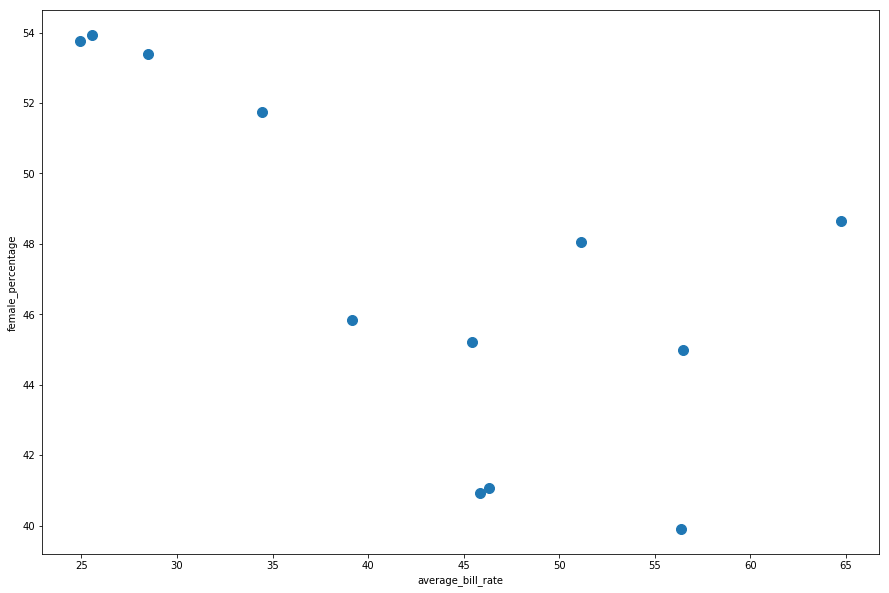

In [54]:
# Build a scatterplot using the dataframes above

scatter_df = bill_rate_df.join(representation_df, how='outer')

scatter_df = scatter_df.join(discrepancy_df, how='outer')

print scatter_df

scatter_df.plot(kind='scatter', x='average_bill_rate', y='female_percentage', figsize=(15, 10), s=100)


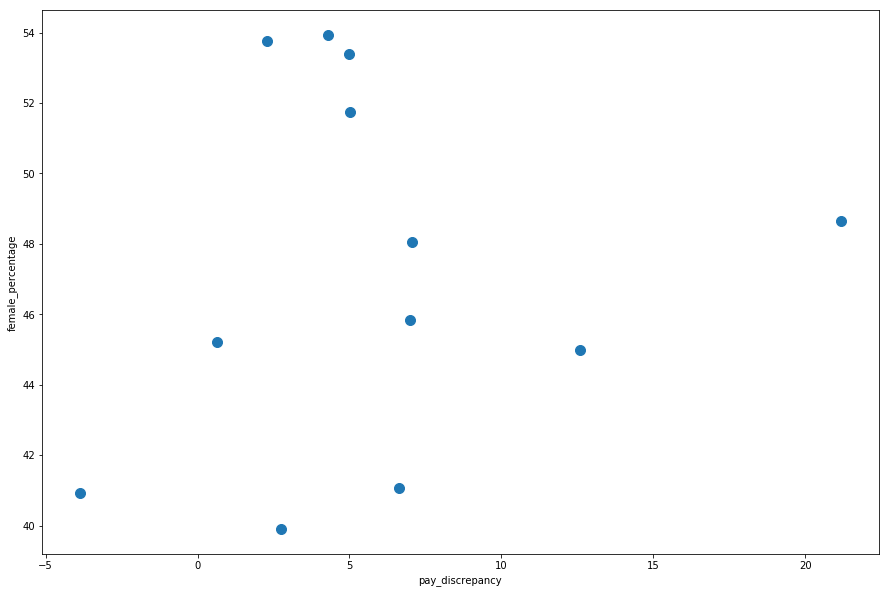

In [56]:
scatter_df.plot(kind='scatter', x='pay_discrepancy', y='female_percentage', figsize=(15, 10), s=100)

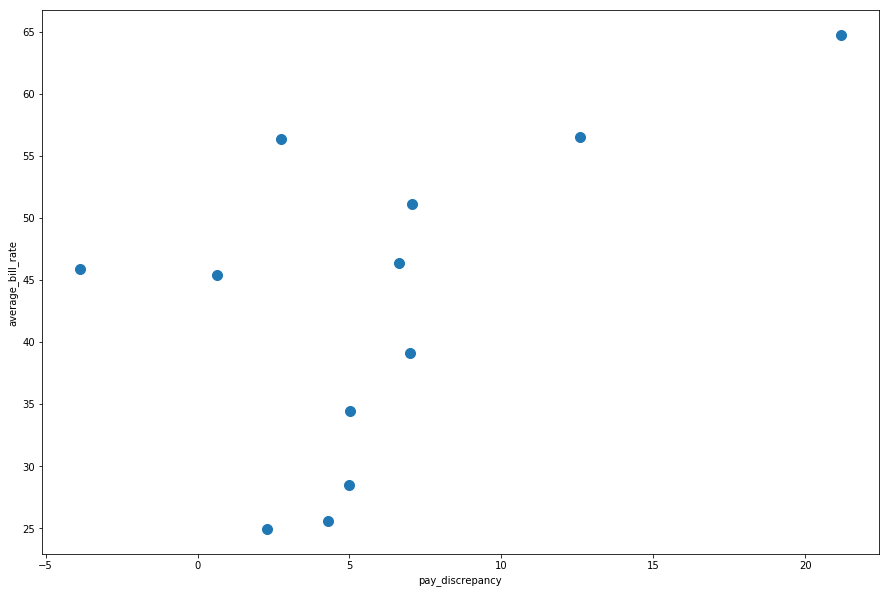

In [61]:
scatter_df.plot(kind='scatter', x='pay_discrepancy', y='average_bill_rate', figsize=(15, 10), s=100)

In [57]:
# Compute correlation between average bill rate and representation of women in job categories

rep_by_rate_df = bill_rate_df.join(representation_df, how='outer')
rep_by_rate_df.corr(method='pearson')

,average_bill_rate,female_percentage
average_bill_rate,1.000000,-0.669768
female_percentage,-0.669768,1.000000


In [59]:
# Compute correlation between pay discrepancy and average bill rate in job categories

disc_by_rate_df = bill_rate_df.join(discrepancy_df, how='outer')
disc_by_rate_df.corr(method='pearson')

,average_bill_rate,pay_discrepancy
average_bill_rate,1.000000,0.516068
pay_discrepancy,0.516068,1.000000


In [60]:
# Compute correlation between pay discrepancy and female representation in job categories

rep_by_discrepancy_df = discrepancy_df.join(representation_df, how='outer')
rep_by_discrepancy_df.corr(method='pearson')

,pay_discrepancy,female_percentage
pay_discrepancy,1.000000,0.148979
female_percentage,0.148979,1.000000


## How does the representation of women in higher-paying professional job categories on Upwork compare to their representation in in these categories offline? 

Job categories on Upwork (proposed equivalent category from BLS): 
- Design & Creative 
- Data Science & Analytics
- Customer Service
- Admin Support
- Accounting & Consulting
- Writing
- Web, Mobile & Software Dev
- Translation
- Sales & Marketing
- Legal
- IT & Networking
- Engineering & Architecture 

Method for choosing proposed equivalent category from BLS:
Based on the definition of these skills from Upwork
